# Environment Setup

In [ ]:
!nvidia-smi

Wed Nov  6 16:41:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:22:00.0 Off |                  Off |
| 30%   36C    P8             17W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from datasets import load_dataset, concatenate_datasets
import torch
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import os
import matplotlib.pyplot as plt
import wandb
import transformers
from datetime import datetime
import logging
from tqdm import tqdm
from collections import Counter

In [ ]:
base_model_id = "microsoft/Phi-3.5-mini-instruct"
data_id = "AlanYky/tweets_instruct_v2"

In [ ]:
torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

model.to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3FlashAttention2(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=307

# Util Functions

In [ ]:
def generate_tweet(instruction, pipe, generation_args):
    # Prepare the messages structure
    messages = [
        {
            "role": "user",
            "content": instruction
        }
    ]

    # Generate the tweet response
    output = pipe(messages, **generation_args)

    # Extract and return the generated tweet text
    return output[0]['generated_text']


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_train_dataset ]
    lengths += [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_val_dataset]
    print(len(lengths))
    print("Max length: ", max(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

def formatting_func(example):
    instruction = example['instruction']
    tweet = example['text']
    return f"<|endoftext|><|user|>\n{instruction} <|end|>\n<|assistant|>\n{tweet}"

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))



# Tokenize Data

In [ ]:
tuning_data_size = 50000

In [ ]:
train_dataset = load_dataset(data_id)

In [ ]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text', 'subset'],
        num_rows: 160398
    })
})

In [ ]:
combined_dataset = concatenate_datasets([train_dataset[subset] for subset in train_dataset])

In [ ]:
combined_dataset

Dataset({
    features: ['instruction', 'text', 'subset'],
    num_rows: 160398
})

In [ ]:
# Shuffle the combined dataset
shuffled_dataset = combined_dataset.shuffle(seed=42)

In [ ]:
shuffled_dataset

Dataset({
    features: ['instruction', 'text', 'subset'],
    num_rows: 160398
})

In [ ]:
tuning_dataset = shuffled_dataset.select(range(tuning_data_size))
# tuning_dataset = shuffled_dataset.select(range(tuning_data_size, len(shuffled_dataset)))

In [ ]:
tuning_dataset

Dataset({
    features: ['instruction', 'text', 'subset'],
    num_rows: 50000
})

In [ ]:
print(tuning_dataset[0])

{'instruction': 'Can you write a tweet to me?', 'text': "Well scratch that it's all sold out ", 'subset': 'general_instruct'}


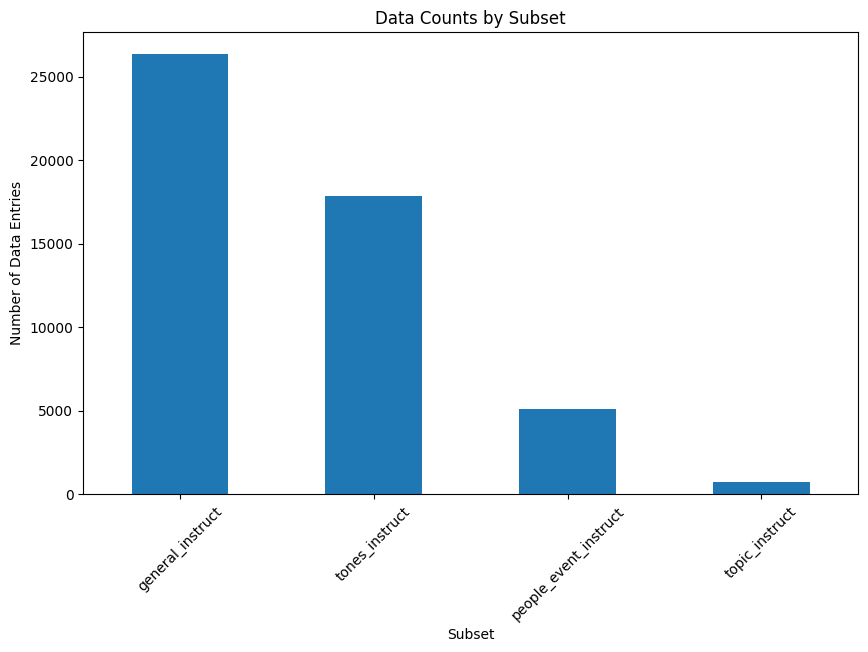

In [ ]:
# Convert to DataFrame
df_graph = pd.DataFrame(tuning_dataset)

# Count data occurrences by subset
subset_counts = df_graph['subset'].value_counts()

# Plotting the subset counts
plt.figure(figsize=(10, 6))
subset_counts.plot(kind='bar')
plt.title("Data Counts by Subset")
plt.xlabel("Subset")
plt.ylabel("Number of Data Entries")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Split into training and validation datasets
validation_dataset = tuning_dataset.select(range(3))  # First 2 samples for validation
training_dataset = tuning_dataset.select(range(3, len(tuning_dataset)))  # Rest for training

# Print the 10 samples in the validation dataset
for i, sample in enumerate(validation_dataset):
    print(f"Sample {i+1}:", sample)
    print("\n")

Sample 1: {'instruction': 'Can you write a tweet to me?', 'text': "Well scratch that it's all sold out ", 'subset': 'general_instruct'}


Sample 2: {'instruction': 'Can you generate a tweet?', 'text': "Whoops - accidently had an ice cream - I'm so crap at this diet stuff - never had to do it before!!! ", 'subset': 'general_instruct'}


Sample 3: {'instruction': 'Generate a human-like tweet to me?', 'text': 'Family is honestly the key to life. I love my family more than anything in the world! ', 'subset': 'general_instruct'}


In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

num_proc must be <= 3. Reducing num_proc to 3 for dataset of size 3.


In [ ]:
tokenizer.decode(tokenized_train_dataset[1]["input_ids"])

"<|endoftext|><|user|> Write a human-like tweet. <|end|><|assistant|> Ok, I'm getting addicted to the Bachelorette. I can't believe Jillian is still keeping Wes and Tanner "

50000
Max length:  246


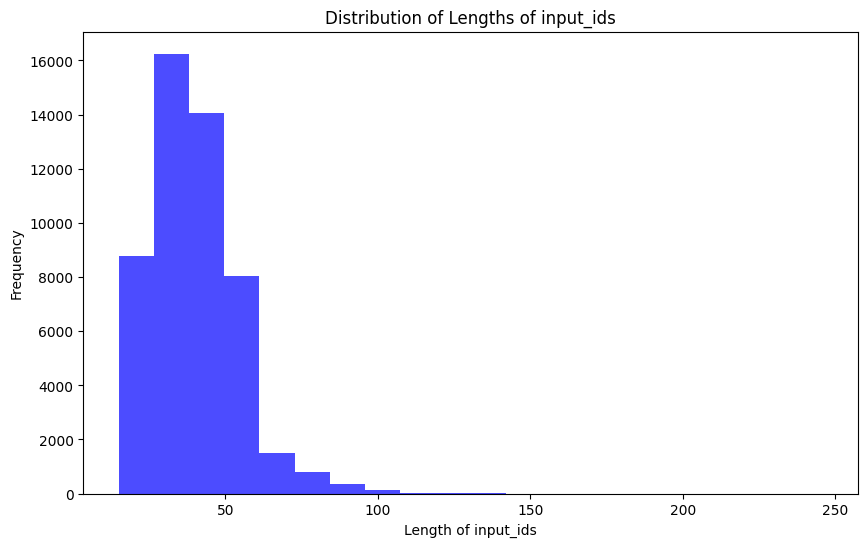

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt_padding(prompt):
    result = tokenizer(
        formatting_func(prompt),
        max_length=100,
        truncation=True,
        padding='max_length',
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

num_proc must be <= 3. Reducing num_proc to 3 for dataset of size 3.


In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(
    training_dataset.column_names
)

tokenized_val_dataset = tokenized_val_dataset.remove_columns(
    validation_dataset.column_names
)


50000
Max length:  100


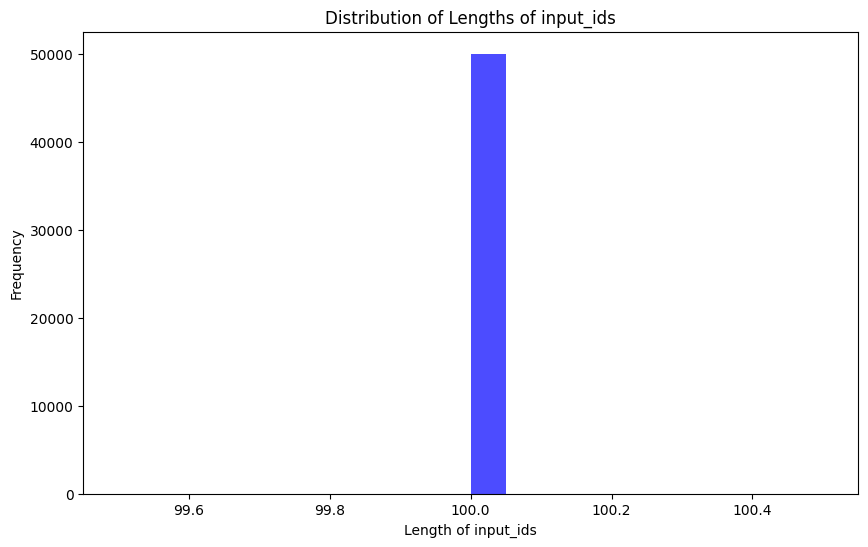

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
len(tokenized_train_dataset[1]["input_ids"])

100

In [ ]:
tokenizer.decode(tokenized_train_dataset[40]["input_ids"])

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Write a human-l

# Base Model Performance

In [ ]:
tweet_generation_prompt = "Can you generate the tweet about NBA"

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

generate_tweet(
    instruction=tweet_generation_prompt,
    pipe=pipe,
    generation_args=generation_args
)

# Tweet Instruct Tuning 50k

In [ ]:
# bd989240e730a8a990308fd969e1a2478fad8371
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yangkaiyam (alanyang5114). Use `wandb login --relogin` to force relogin


True

In [ ]:
logging.getLogger("transformers").setLevel(logging.DEBUG)
os.environ["WANDB_PROJECT"]="phi35-tweet-50k"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
run_name = "phi3_2"
output_dir = "./" + run_name

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset.select(range(1)),
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        num_train_epochs=1,
        output_dir=output_dir,
        warmup_steps=1,
        gradient_accumulation_steps=1,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="no",               # Disable checkpoint saving
        # save_steps=1,
        # save_total_limit = 1,                     # Mixed precision for efficiency
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 49,997
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 49,997
  Number of trainable parameters = 3,821,079,552
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
100,2.356300,1.973352


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


Step,Training Loss,Validation Loss
100,2.356300,1.973352
200,2.454500,2.057904
300,2.213600,1.982410
400,2.290600,1.954861
500,2.180000,1.798186
600,2.209000,1.831666
700,2.254000,1.872657
800,2.366800,1.857575
900,2.095100,1.884069
1000,2.341600,1.975032


In [ ]:
wandb.finish()

eval/loss,▇▆█▆▆▄▅▅▄▄▃▄▄▃▃▃▂▁▃▃▂▂▂▁▂▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂
eval/runtime,▂▃▃▁▂▂▄▂▃▄▂▂▂▃▃▃▃▄▆▄▆▇▄▃▅▅▄▅▅▄▅▅▄▄▄▅▆▅▅█
eval/samples_per_second,▆▃▇▆▅▆█▄█▆██▇█▇▇▇▄▅▇▆▅▆▄▅▄▃▆▄▅▃▃▅█▁▃▅▄▃▅
eval/steps_per_second,▇▇▇▇▆▆▇▅▇▇▆▆█▆█▇▆▅▇▇▇▅▁▇▅▆▇▆▄▃▅▆▆▅▆▆▄▅▅▄
train/epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███████
train/global_step,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▄▅▄▃▂▅▂▃▁▂▃▂▂▆▂▂▇▃▂▂▃▁▃▃▄▄▃▁▃▁▂▃▃█▂▅▃▄▄▄
train/learning_rate,█████▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁
train/loss,▅▆▅▄▅▄▃▆▇▃▅█▄▂▄▃▇▄▅▄▄▄▃▃▆▃▂▇▅▄▃▄▄▂▁▆▄▂▃▃
eval/loss,1.65008
eval/runtime,0.0604


In [ ]:
model.push_to_hub("AlanYky/phi-3.5_tweets_instruct_50k")

Configuration saved in /tmp/tmp_629k_bm/config.json
Configuration saved in /tmp/tmp_629k_bm/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmp_629k_bm/model.safetensors.index.json.
Uploading the following files to AlanYky/phi-3.5_tweets_instruct_50k: config.json,generation_config.json,model-00001-of-00002.safetensors,model-00002-of-00002.safetensors,model.safetensors.index.json,README.md


model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/AlanYky/phi-3.5_tweets_instruct_50k/commit/6deea1184184693275e47208422fb9e0fd43df18', commit_message='Upload Phi3ForCausalLM', commit_description='', oid='6deea1184184693275e47208422fb9e0fd43df18', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AlanYky/phi-3.5_tweets_instruct_50k', endpoint='https://huggingface.co', repo_type='model', repo_id='AlanYky/phi-3.5_tweets_instruct_50k'), pr_revision=None, pr_num=None)

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          91G  9.5G   82G  11% /
tmpfs            64M     0   64M   0% /dev
shm              15G  568K   15G   1% /dev/shm
/dev/loop20     3.1T  1.1T  2.1T  35% /etc/hosts
/dev/sda2       3.5T  1.2T  2.2T  36% /usr/bin/nvidia-smi
tmpfs           126G   12K  126G   1% /proc/driver/nvidia
tmpfs           126G  4.0K  126G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs            26G   18M   26G   1% /run/nvidia-persistenced/socket
tmpfs           126G     0  126G   0% /proc/asound
tmpfs           126G     0  126G   0% /proc/acpi
tmpfs           126G     0  126G   0% /proc/scsi
tmpfs           126G     0  126G   0% /sys/firmware
tmpfs           126G     0  126G   0% /sys/devices/virtual/powercap
